In [1]:
import numpy as np
import numba
import scipy.sparse as ssp
import scipy.stats
import time
import sys
import pdb
from functools import partial
# %load_ext line_profiler
%load_ext autoreload
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

In [2]:
from QH_ED import landau
from QH_ED import utils
from QH_ED import hilbert
from QH_ED import observables
from functools import partial

## A simple calculation of 8 electrons at $\nu=1/3$ in the LLL 

In [40]:
Nphi = 24
Ne = 8
sector = 4
Nth = 4

torus1 = landau.Torus(Nphi, aspect_ratio=1.0)
hamParams = {'alpha': 1.0, 'n': 0, 'Nphi': Nphi} # mass anisotropy, Landau level index
vParams1 = {'power': (1.0, {'n': 1, 'x': np.inf})} # Coulomb power law, Gaussian cut-off
vParams2 = {'haldane': (1.0, {'Vm': [0, 1]})} # Haldane pseudopotential

pot1 = landau.Potential(torus=torus1, vParams=vParams1, hamParams=hamParams)
pot1.setV2()
T41 = np.real(utils.Utils.make4tensorsym(torus1, pot1.V2))

pot2 = landau.Potential(torus=torus1, vParams=vParams2, hamParams=hamParams)
pot2.setV2()
T42 = np.real(utils.Utils.make4tensorsym(torus1, pot2.V2))

hilb_s, hilbLen_s = utils.Utils.getHilb(Nphi, Ne, sector)
dictx = hilbert.getDict(hilb_s)
NH = len(hilb_s)

dij1 = hilbert.getMatAux(Nphi, Ne, NH, hilb_s, hilbLen_s, T41, dictx, Nth)
dij2 = hilbert.getMatAux(Nphi, Ne, NH, hilb_s, hilbLen_s, T42, dictx, Nth)

HMat1 = hilbert.dijToCsr(dij1, NH)
HMat2 = hilbert.dijToCsr(dij2, NH)

In [41]:
E1, V1 = ssp.linalg.eigsh(HMat1, k=6, which='SA')
E2, V2 = ssp.linalg.eigsh(HMat2, k=6, which='SA')

## ground state

In [42]:
print("Coulomb: {0:.6f}".format(E1[0]/Ne))
print("Haldane: {0:.6f}".format(E2[0]/Ne))

Coulomb: -0.252519
Haldane: -0.291667


In [43]:
print("Wavefunction overlap: {0:.6f}".format(np.dot(V1[:, 0], V2[:, 0])**2))

Wavefunction overlap: 0.980256


In [44]:
hilbObj1 = hilbert.Hilbert(Nphi=Nphi, Ne=Ne, NH=NH, hilb=hilb_s, hilbLen=hilbLen_s, dictx=dictx)
obs1 = observables.Observables(torus1, hamParams, hilbObj1)

In [45]:
nX = 30
x_diag = 0.5 * np.arange(nX+1) * torus1.Lx / nX
r_arr = np.c_[x_diag, x_diag]
gRdiag1 = obs1.gr(r_arr, V1[:, 0])
gRdiag2 = obs1.gr(r_arr, V2[:, 0])

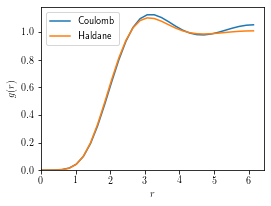

In [46]:
f, ax = plt.subplots(figsize=(4,3))
ax.plot(x_diag, gRdiag1, label='Coulomb')
ax.plot(x_diag, gRdiag2, label='Haldane')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$g(r)$')
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend(loc='best')